In [1]:
from symmer.symplectic import PauliwordOp
from symmer.projection import (
    S3_projection, QubitTapering, CS_VQE_LW, CS_VQE,
    StabilizerIdentification, ObservableBiasing, stabilizer_walk
)
from symmer.symplectic import *
from symmer.utils import exact_gs_energy, gf2_gaus_elim, gf2_basis_for_gf2_rref
from symmer.chem import geometry_from_pubchem, MoleculeBuilder, get_T2_mp2
from matplotlib import pyplot as plt
from functools import reduce
from openfermion import jordan_wigner
from symmer.utils import QubitOperator_to_dict
from symmer.utils import random_symplectic_matrix
import json

In [2]:
with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
with open('../data/score_data.json', 'r') as infile:
    scoring_data = json.load(infile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiOH_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'NaH_STO-3G_SINGLET', 'LiH_3-21G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'HF_3-21G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'NH4+_STO-3G_SINGLET', 'MgH2_STO-3G_SINGLET', 'Mg_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-

In [3]:
molecules = [
    'Be_STO-3G_SINGLET',
    'HF_STO-3G_SINGLET',
    'LiH_STO-3G_SINGLET',
    'OH-_STO-3G_SINGLET',
    'BeH2_STO-3G_SINGLET',
    'H2O_STO-3G_SINGLET'
]

random_stab_results = {}

for speciesname in molecules:

    mol_data = molecule_geometries[speciesname]
    atoms  = mol_data['atoms']
    coords = mol_data['coords']
    charge = mol_data['charge']
    basis = mol_data['basis']
    geometry = list(zip(atoms, coords))
    molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

    MP2 = PauliwordOp(
        QubitOperator_to_dict(
            jordan_wigner(
                get_T2_mp2(
                    molecule.pyscf_obj.pyscf_mp2.t2)
            ), 
            molecule.n_qubits)
    ).sort()

    # taper the Hamiltonian
    taper_hamiltonian = QubitTapering(molecule.H_q)
    hf_array = molecule.H_fermion.hf_comp_basis_state
    taper_hamiltonian.stabilizers.update_sector(hf_array)
    ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
    ucc_tap = taper_hamiltonian.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
    mp2_tap = taper_hamiltonian.taper_it(aux_operator=MP2, ref_state=hf_array)
    hf_tapered = taper_hamiltonian.tapered_ref_state

    # initiate stabilizer identification classes
    Hc_stabilizers = StabilizerIdentification(ham_tap)
    CC_stabilizers = StabilizerIdentification(ucc_tap)
    MP_stabilizers = StabilizerIdentification(mp2_tap)
    HL_gap = np.where(hf_tapered==0)[0][0]-.5
    ham_biasing = ObservableBiasing(base_operator=ham_tap, HOMO_LUMO_gap=HL_gap)

    # build CS-VQE model
    cs_vqe_cc = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
    cs_vqe_mp2 = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=mp2_tap, noncontextual_form='diag')
    cs_vqe_ham = CS_VQE(ham_tap, hf_tapered, noncontextual_form='legacy')
    
    results_out={
        'n_qubits': int(ham_tap.n_qubits),
        'n_qubits_full': int(molecule.n_qubits),
        'hf_energy': molecule.hf_energy,
        'mp2_energy': molecule.mp2_energy,
        'ccsd_energy': molecule.ccsd_energy,
        'fci_energy': molecule.fci_energy,
        'stab_data':{}
    }

    for n_stabs in range(1, ham_tap.n_qubits):
        print(f'*****{n_stabs}*****')
        n_samples = 0
        data = []
        while n_samples<=2**ham_tap.n_qubits:
            try:
                S = StabilizerOp(random_symplectic_matrix(ham_tap.n_qubits, n_stabs, diagonal=True), np.ones(n_stabs))
                stab_score_cc = cs_vqe_cc.basis_score(S)
                stab_score_mp2 = cs_vqe_mp2.basis_score(S)
                stab_score_ham = cs_vqe_ham.basis_score(S)
                ham_cs = cs_vqe_cc.project_onto_subspace(S)
                matrix = ham_cs.to_sparse_matrix
                cs_energy = exact_gs_energy(matrix)[0]
                data.append([stab_score_ham, stab_score_mp2, stab_score_cc, cs_energy])
                n_samples+=1
                if n_samples%100==0:
                    print(n_samples)
            except:
                pass
        results_out['stab_data'][ham_tap.n_qubits - n_stabs] = data
        print()
        
    random_stab_results[speciesname] = results_out


Molecule geometry:
Be	0	0	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -14.351880476202023
MP2 energy:  -14.376238850841515
CCSD energy: -14.403650751752787
FCI energy:  -14.403655108067682


Number of qubits: 10
*****1*****

*****2*****

*****3*****

*****4*****

Molecule geometry:
H	0.0	0.0	0.099457
F	0.0	0.0	-0.895109

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -98.5710110679765
MP2 energy:  -98.5919816567085
CCSD energy: -98.60330177389835
FCI energy:  -98.6033017772588


Number of qubits: 12
*****1*****
100
200

*****2*****
100
200

*****3*****
100
200

*****4*****
100
200

*****5*****
100
200

*****6*****
100
200

*****7*****
100
200

Molecule geometry:
Li	0.0	0.0	0.3868
H	0.0	0.0	-1.1605

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -7.863115321486979
MP2 energy:  -7.8756252760669065
CCSD energy: -7.88275231299711
FCI energy:  -7.882762230971982


Number of qubits: 12
*****1*****

In [12]:
with open('../data/randomized_stabilizer_scores.json', 'w') as outfile:
    json.dump(random_stab_results, outfile)

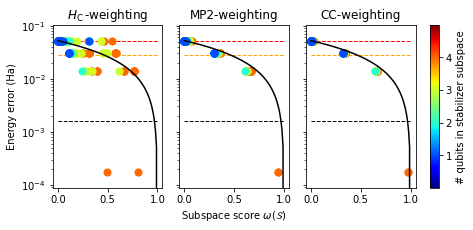

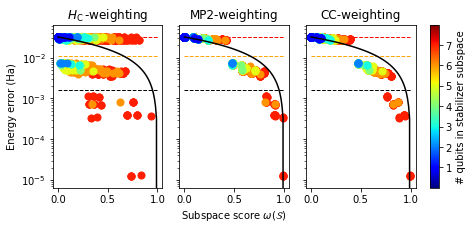

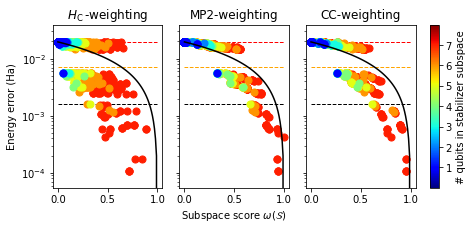

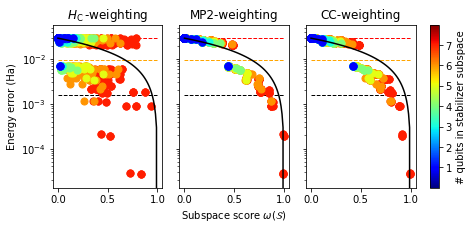

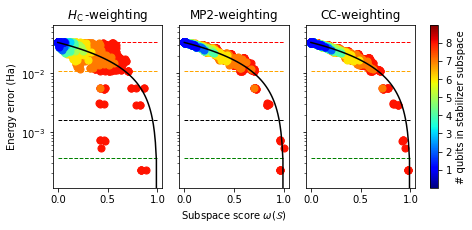

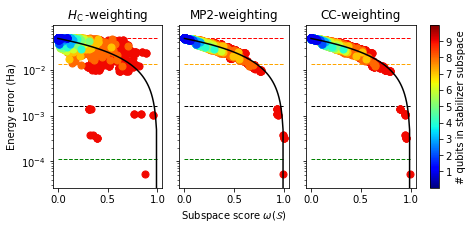

In [68]:
from matplotlib.pyplot import Normalize

with open('../data/randomized_stabilizer_scores.json', 'r') as infile:
    random_stab_results = json.load(infile)

for speciesname in molecules:

    fig,axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(7,3),
                               gridspec_kw={'width_ratios': [10, 10, 10, 1]})

    data = random_stab_results[speciesname]
    n_qubits = data['n_qubits']
    n_qubits_full = data['n_qubits_full']
    hf_energy = data['hf_energy']
    mp2_energy = data['mp2_energy']
    ccsd_energy = data['ccsd_energy']
    fci_energy = data['fci_energy']
    ham_mp2_ucc_nrg = data['stab_data']
    increments=[]
    
    Y_min = []
    for n_sim_qubits,results in ham_mp2_ucc_nrg.items():
        ratio = int(n_sim_qubits)/n_qubits
        increments.append(ratio)
        c = plt.cm.jet(ratio)
        X_ham, X_mp2, X_ucc, X_nrg = zip(*results)
        X_ham = np.array(X_ham)
        X_mp2 = np.array(X_mp2)
        X_ucc = np.array(X_ucc)
        Y_nrg = np.array(X_nrg) - fci_energy
        Y_min.append(min(Y_nrg))

        axes[0].scatter(X_ham,Y_nrg,marker='o',color=c,s=50,zorder=1,alpha=1)
        axes[1].scatter(X_mp2,Y_nrg,marker='o',color=c,s=50,zorder=1,alpha=1)
        axes[2].scatter(X_ucc,Y_nrg,marker='o',color=c,s=50,zorder=1,alpha=1)

    Y_ideal = np.linspace(hf_energy-fci_energy, 0, 100)
    X_ideal = np.linspace(0,1,100)
    axes[0].plot(X_ideal, Y_ideal, color='black')
    axes[1].plot(X_ideal, Y_ideal, color='black')
    axes[2].plot(X_ideal, Y_ideal, color='black')
    
    def plot_lines(axis):
        axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
        axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
        axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
        axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')
    plot_lines(axes[0])
    plot_lines(axes[1])
    plot_lines(axes[2])

    keys = list(ham_mp2_ucc_nrg.keys())
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                         ax=axes[3], label='# qubits in stabilizer subspace', ticks=increments, fraction=1.2)
    cbar.ax.set_yticklabels(keys)

    axes[0].set_title('$H_{\\mathrm{C}}\,$-weighting')
    axes[1].set_title('MP2-weighting')
    axes[2].set_title('CC-weighting')
    axes[0].set_ylabel('Energy error (Ha)')
    axes[1].set_xlabel('Subspace score $\omega(\mathcal{S})$')
    axes[3].set_visible(False)    
    
    axes[1].set_ylim(min(Y_min)/2, 2*(hf_energy-fci_energy))
    axes[1].set_yscale('log')
    
    filename = f'../plots/{speciesname}_random_score_vs_energy.png'
    fig.savefig(filename, dpi=300, bbox_inches='tight')

In [39]:
np.linspace(0.1, 0.01, 100)

array([0.1       , 0.09909091, 0.09818182, 0.09727273, 0.09636364,
       0.09545455, 0.09454545, 0.09363636, 0.09272727, 0.09181818,
       0.09090909, 0.09      , 0.08909091, 0.08818182, 0.08727273,
       0.08636364, 0.08545455, 0.08454545, 0.08363636, 0.08272727,
       0.08181818, 0.08090909, 0.08      , 0.07909091, 0.07818182,
       0.07727273, 0.07636364, 0.07545455, 0.07454545, 0.07363636,
       0.07272727, 0.07181818, 0.07090909, 0.07      , 0.06909091,
       0.06818182, 0.06727273, 0.06636364, 0.06545455, 0.06454545,
       0.06363636, 0.06272727, 0.06181818, 0.06090909, 0.06      ,
       0.05909091, 0.05818182, 0.05727273, 0.05636364, 0.05545455,
       0.05454545, 0.05363636, 0.05272727, 0.05181818, 0.05090909,
       0.05      , 0.04909091, 0.04818182, 0.04727273, 0.04636364,
       0.04545455, 0.04454545, 0.04363636, 0.04272727, 0.04181818,
       0.04090909, 0.04      , 0.03909091, 0.03818182, 0.03727273,
       0.03636364, 0.03545455, 0.03454545, 0.03363636, 0.03272

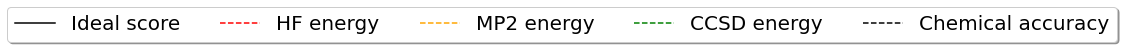

In [30]:
# plot legend
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(0,0))
ax.plot([], [], label='Ideal score', color='black', zorder=2)
ax.hlines(0, 0, 0, ls='--', color='red', zorder=0, label='HF energy')
ax.hlines(0, 0, 0, ls='--', color='orange', zorder=0, label='MP2 energy')
ax.hlines(0, 0, 0, ls='--', color='green', zorder=0, label='CCSD energy')
ax.hlines(0, 0, 0, ls='--', color='black', zorder=0, label='Chemical accuracy')



#ax.plot([], color='black', zorder=1, label='$S^{m+c/n}$')
#ax.scatter([],[], marker='+',s=200, color='black', label='Sampling average')
handles, labels = ax.get_legend_handles_labels()
order = [0,1,2,3,4] #[1,4,2,0,3]
ax.axis('off')
plt.legend(handles = [handles[i] for i in order],
                       labels  = [labels[i] for i in order],
                       loc="lower center",   # Position of legend
                       borderaxespad=0.1,    # Small spacing around legend box
                       ncol=5,
                       bbox_to_anchor=(0,3),
                       fancybox=True, 
                       shadow=True,
                       prop={'size':20})

fig.savefig('../plots/random_score_vs_energy_legend.png', dpi=300, bbox_inches='tight')